[View in Colaboratory](https://colab.research.google.com/github/Leocodefocus/project/blob/master/feature_sets.ipynb)

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

#接口初始化
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

#数据读取
california_housing_dataframe = pd.read_csv(
    "https://storage.googleapis.com/mledu-datasets/california_housing_train.csv",
    sep=",")
#重建索引，索引为NaN的会被填充
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
#预处理，提取以及处理特征数据
def preprocess_features(california_housing_dataframe):
  #提取特定特征数据
  selected_features = california_housing_dataframe[
      ["latitude",
       "longitude",
       "housing_median_age",
       "total_rooms",
       "total_bedrooms",
       "population",
       "households",
       "median_income"]]
  #备份特征数据
  processed_features = selected_features.copy()
  #增加特征rooms_per_person
  processed_features["rooms_per_person"] = (
      california_housing_dataframe["total_rooms"] /
      california_housing_dataframe["population"])
  return processed_features

In [0]:
#预处理，提取目标特征以及处理
def preprocess_targets(california_housing_dataframe):
  output_targets = pd.DataFrame()
  output_targets["median_house_value"] = (
      california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [0]:
#构造特征列
def construct_feature_columns(input_features):
  #set() 去除重复
  #tf.feature_column.numeric_column()
  return set([tf.feature_column.numeric_column(my_feature) 
              for my_feature in input_features])

In [0]:
#定义输入
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epochs=None):
  
  #处理特征为字典结构，键值为array类型
  features = {key:np.array(value) for key,value in dict(features).items()}
  
  #构建数据集，定义Barch_size and num_epochs
  ds = Dataset.from_tensor_slices((features,targets))
  ds = ds.batch(batch_size).repeat(num_epochs)
  
  #True:重组数据
  if shuffle:
    ds = ds.shuffle(10000)
  
  #返回数据的下一个集合
  features,labels = ds.make_one_shot_iterator().get_next()
  return features,labels

In [0]:
def train_model(learning_rate,steps,batch_size,training_examples,training_targets,
    validation_examples,validation_targets):
  periods = 10
  steps_per_period = steps / periods
  
  #创建一个线性回归对象
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns = construct_feature_columns(training_examples),
      optimizer = my_optimizer
  )
  
  #创建输入函数
  training_input_fn = lambda: my_input_fn(training_examples,
                                          training_targets["median_house_value"],
                                          batch_size=batch_size)
  predict_training_input_fn = lambda:my_input_fn(training_examples,
                                                training_targets["median_house_value"],
                                                num_epochs=1,
                                                shuffle=False)
  predict_validation_input_fn = lambda:my_input_fn(validation_examples,
                                                  validation_targets["median_house_value"],
                                                  num_epochs=1,
                                                  shuffle=False)
  #训练模型，但是为了能周期性访问损失矩阵，使用循环
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range(0,periods):
    linear_regressor.train(
        input_fn = training_input_fn,
        steps = steps_per_period,
    )
    # 计算预测值
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item["predictions"][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
    
    #计算训练和验证损失
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions,training_targets)
    )
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions,validation_targets)
    )
    
    #打印当前损失
    print(" period %02d : %0.2f"%(period,training_root_mean_squared_error))
    #吧损失矩阵加入列表
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  #输出损失矩阵图
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse,label="training")
  plt.plot(validation_rmse,label="validation")
  plt.legend()
  
  return linear_regressor

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2632.0,537.2,1421.5,498.9,3.9,2.0
std,2.1,2.0,12.6,2164.0,417.6,1109.9,380.1,1.9,1.1
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1463.0,297.0,790.8,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2120.0,431.0,1162.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3126.2,644.0,1719.0,598.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2671.6,544.8,1449.1,506.7,3.9,2.0
std,2.1,2.0,12.6,2217.8,430.8,1234.2,394.9,1.9,1.3
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1460.8,297.0,788.0,283.0,2.6,1.5
50%,34.3,-118.5,29.0,2153.0,441.0,1177.5,412.0,3.6,2.0
75%,37.7,-118.0,37.0,3201.2,659.0,1730.0,618.0,4.8,2.3
max,41.9,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,206.7
std,115.6
min,15.0
25%,119.5
50%,179.2
75%,263.8
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.7
std,116.8
min,15.0
25%,119.4
50%,182.9
75%,268.0
max,500.0


Training model...
RMSE (on training data):
 period 00 : 167.62
 period 01 : 170.20
 period 02 : 170.55
 period 03 : 171.43
 period 04 : 169.71
 period 05 : 168.27
 period 06 : 166.44
 period 07 : 167.18
 period 08 : 164.30
 period 09 : 160.40
Model training finished.


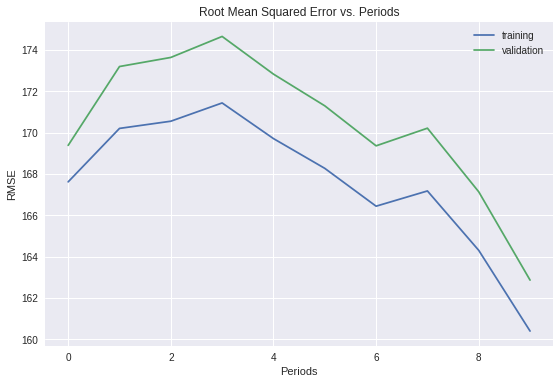

In [14]:
#选择前12000条数据作为训练集
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

#选择后5000条数据作为验证集
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

#再次观察我们选择的集合是否合适
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

#相关矩阵展现了两两比较的相关性
#皮尔逊相关系数
#-1.0:完全负相关
#0:不相关
#1.0:完全正相关
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()
print("======================================================================")
minimal_features = [
    "housing_median_age",
    "rooms_per_person",
    "median_income",
    "households",
    "latitude"
]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate=0.001,
    steps = 500,
    batch_size=5,
    training_examples = minimal_training_examples,
    training_targets = training_targets,
    validation_examples = minimal_validation_examples,
    validation_targets = validation_targets)